In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from rich import print

### RandomForest

In [2]:
df = pd.read_csv('train_binary.csv').sample(frac=0.1)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop(['is_benign', 'category', 'attack'], axis=1),
    df['is_benign'],
    train_size=0.7
)

#### Choosing the number of trees to use in the ensemble

In a Random Forest, each tree is trained on a subset of the training data selected by bootstrap sampling. The "out-of-bag" (OOB) data is the portion of the training data that was not selected during the bootstrap sampling. The OOB error is a measure of the model's predictive performance.

Observing the OOB estimation variation with the number of trees helps understanding after how many trees the model stabilizes, thus what's the optimal number of threes to train our RandomForest on. The point where the OOB error stops improving/fluctuating significantly indicates that the model generalizes well to unseen data, and adding more trees does not meaningfully improve the model's performance.


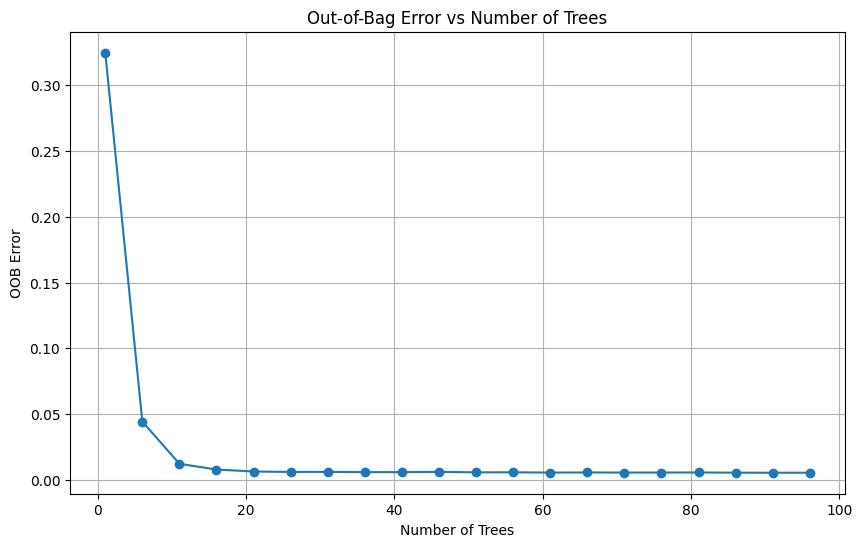

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Extract the OOB error for each number of trees: we try one model every 5 increased number of trees
oob_errors = []
n_trees_values = range(1, 100, 5)
for n_trees in n_trees_values:
    temp_forest = RandomForestClassifier(n_estimators=n_trees, oob_score=True, random_state=42)
    temp_forest.fit(X_train, y_train)
    oob_errors.append(1 - temp_forest.oob_score_)

# Plot the OOB error
plt.figure(figsize=(10, 6))
plt.plot(n_trees_values, oob_errors, marker='o', linestyle='-')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("Out-of-Bag Error vs Number of Trees")
plt.grid(True)
plt.show()

#### Optimising Hyperparameters

We used a Grid Search, with 3-folds cross validation, to choose the best function to measure the quality of a split ('criterion') and the best maximum depth of the trees in our ensemble ('max_depth')

We also defined a **custom scorer** function to define what we intend as "best model": the one that maximises the average of our evaluation metrics.

In [5]:
from sklearn.metrics import make_scorer

# Define average_score to take y_true and y_pred
def average_score(y_true, y_pred):
    return (accuracy_score(y_true, y_pred) + 
            precision_score(y_true, y_pred) + 
            recall_score(y_true, y_pred) + 
            f1_score(y_true, y_pred)) / 4

# Use make_scorer with the fixed average_score
average_scorer = make_scorer(average_score)

# Define RandomForestClassifier and parameter grid
rnd_forest = RandomForestClassifier()

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'random_state': [42]
}

# Set up GridSearchCV
search = GridSearchCV(
    rnd_forest,
    param_grid,
    scoring=average_scorer,  # Pass the custom scorer
    refit=True,
    cv=3,
    verbose=True
)

# Fit the grid search
search.fit(X_train, y_train)

# Access the best model and parameters
best_model = search.best_estimator_
print("\nBest Parameters by Average Score:", search.best_params_)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


Best Parameters by Average Score:
{'criterion': 'entropy', 'max_depth': None, 'random_state': 42}

#### Predicting and Evaluating the model

In [6]:
y_pred = best_model.predict(X_val)

In [7]:
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

metrics_rnd = [
    acc,
    prec,
    rec,
    f1
]

print(f"Accuracy:        {acc:.5f}")
print(f"Precision:       {prec:.5f}")
print(f"Recall:          {rec:.5f}")
print(f"F1:              {f1:.5f}")

Accuracy:        0.99585

Precision:       0.99342

Recall:          0.99826

F1:              0.99583

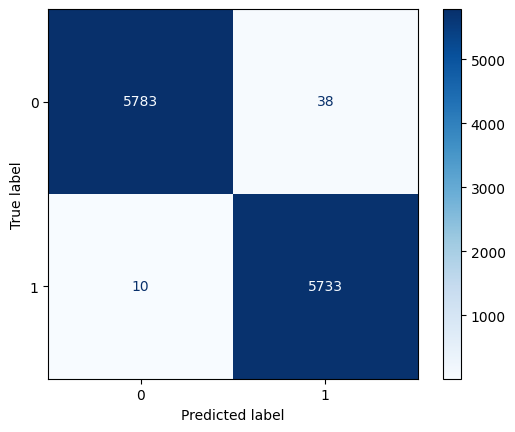

In [8]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()